# Hoja de trabajo 2
## Autores
* Josue Valenzuela 171001
* Marcos Gutierrez 17909
* Fernando Hengstenberg 17699
* Raul Monzon 17014

##  Análisis Exploratorio  

### Preparacion inicial de los dat

In [0]:
from sklearn import datasets
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from fcmeans import FCM
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from seaborn import scatterplot as fuzsb

In [0]:
data = pd.read_csv('tmdb-movies.csv', na_values=['NA'])

In [0]:
# Transform categoric vars to lists
data['first_cast'] = data['cast'].str.split("|",1).str[0]
data['first_keywords'] = data['keywords'].str.split("|",1).str[0]
data['first_genres'] = data['genres'].str.split("|",1).str[0]
data['first_production_companies'] = data['production_companies'].str.split("|",1).str[0]

data['cast'] = data['cast'].str.split("|")
data['keywords'] = data['keywords'].str.split("|")
data['genres'] = data['genres'].str.split("|")
data['production_companies'] = data['production_companies'].str.split("|")

data.dropna().head(2)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,first_cast,first_keywords,first_genres,first_production_companies
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,"[monster, dna, tyrannosaurus rex, velociraptor...",Twenty-two years after the events of Jurassic ...,124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,Chris Pratt,monster,Action,Universal Studios
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,"[future, chase, post-apocalyptic, dystopia, au...",An apocalyptic story set in the furthest reach...,120,"[Action, Adventure, Science Fiction, Thriller]","[Village Roadshow Pictures, Kennedy Miller Pro...",5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08,Tom Hardy,future,Action,Village Roadshow Pictures


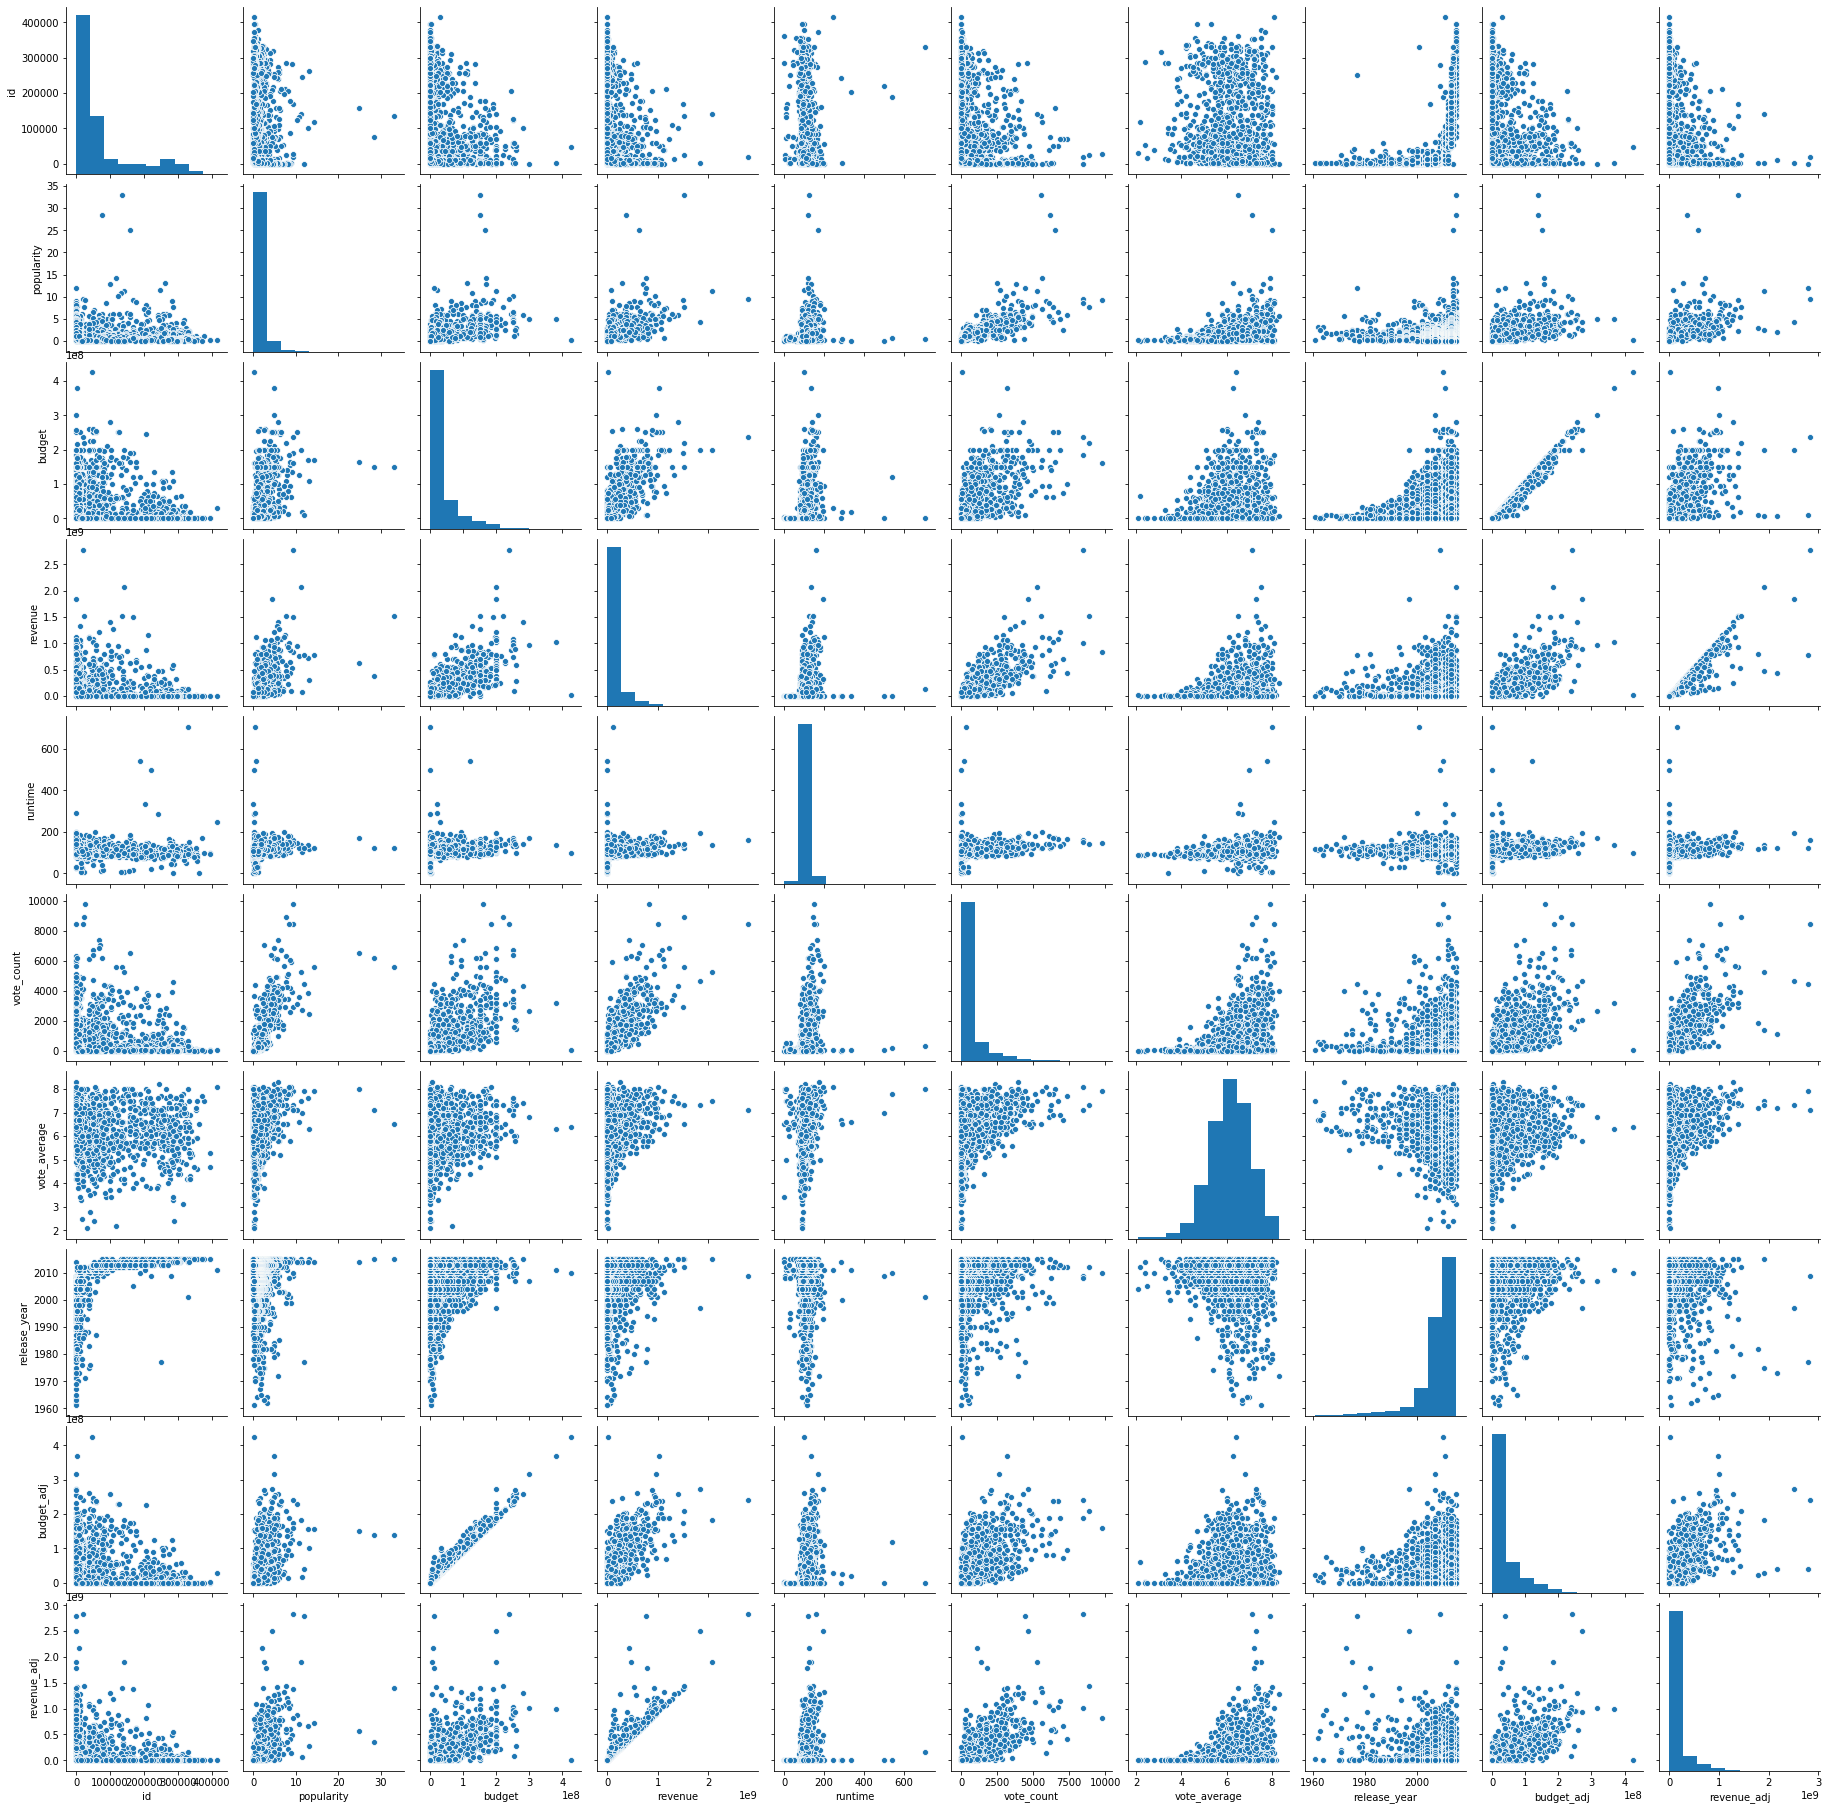

In [0]:
# Nos damos una idea de como estan almacenados los datos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
sb.pairplot(data.dropna())

### Películas que ganaron más?

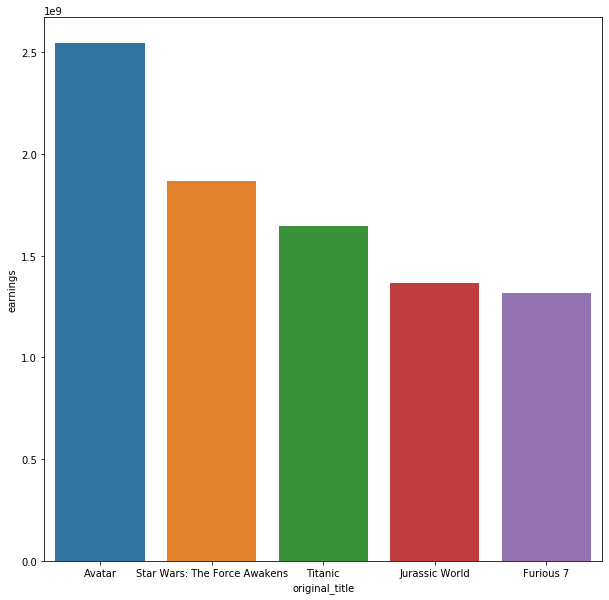

In [0]:
data['earnings'] = data[['budget', 'revenue']].apply(lambda row: row['revenue'] - row['budget'], axis=1)
plt.subplots(figsize=(10, 10))
sb.barplot(y='earnings', x='original_title', data=data.sort_values('earnings', ascending=False).head(5))

### Películas que recuperaron presupuesto?

In [0]:
data.loc[data.earnings >= 0]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,first_cast,first_keywords,first_genres,first_production_companies,earnings
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,"[monster, dna, tyrannosaurus rex, velociraptor...",Twenty-two years after the events of Jurassic ...,124,"[Action, Adventure, Science Fiction, Thriller]","[Universal Studios, Amblin Entertainment, Lege...",6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09,Chris Pratt,monster,Action,Universal Studios,1363528810
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,"[future, chase, post-apocalyptic, dystopia, au...",An apocalyptic story set in the furthest reach...,120,"[Action, Adventure, Science Fiction, Thriller]","[Village Roadshow Pictures, Kennedy Miller Pro...",5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08,Tom Hardy,future,Action,Village Roadshow Pictures,228436354
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,"[Shailene Woodley, Theo James, Kate Winslet, A...",http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,"[based on novel, revolution, dystopia, sequel,...",Beatrice Prior must confront her inner demons ...,119,"[Adventure, Science Fiction, Thriller]","[Summit Entertainment, Mandeville Films, Red W...",3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08,Shailene Woodley,based on novel,Adventure,Summit Entertainment,185238201
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,"[android, spaceship, jedi, space opera, 3d]",Thirty years after defeating the Galactic Empi...,136,"[Action, Adventure, Science Fiction, Fantasy]","[Lucasfilm, Truenorth Productions, Bad Robot]",12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09,Harrison Ford,android,Action,Lucasfilm,1868178225
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",http://www.furious7.com/,James Wan,Vengeance Hits Home,"[car race, speed, revenge, suspense, car]",Deckard Shaw seeks revenge against Dominic Tor...,137,"[Action, Crime, Thriller]","[Universal Pictures, Original Film, Media Righ...",4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09,Vin Diesel,car race,Action,Universal Pictures,1316249360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10860,5060,tt0060214,0.087034,0,0,Carry On Screaming!,"[Kenneth Williams, Jim Dale, Harry H. Corbett,...",NaN,Gerald Thomas,Carry On Screaming with the Hilarious CARRY ON...,"[monster, carry on, horror spoof]",The sinister Dr Watt has an evil scheme going....,87,[Comedy],"[Peter Rogers Productions, Anglo-Amalgamated F...",5/20/66,13,7.0,1966,0.000000e+00,0.000000e+00,Kenneth Williams,monster,Comedy,Peter Rogers Productions,0
10861,21,tt0060371,0.080598,0,0,The Endless Summer,"[Michael Hynson, Robert August, Lord 'Tally Ho...",NaN,Bruce Brown,NaN,"[surfer, surfboard, surfing]","The Endless Summer, by Bruce Brown, is one of ...",95,[Documentary],[Bruce Brown Films],6/15/66,11,7.4,1966,0.000000e+00,0.000000e+00,Michael Hynson,surfer,Documentary,Bruce Brown Films,0
10862,20379,tt0060472,0.065543,0,0,Grand Prix,"[James Garner, Eva Marie Saint, Yves Montand, ...",NaN,John Frankenheimer,Cinerama sweeps YOU into a drama of speed and ...,"[car race, racing, formula 1]",Grand Prix driver Pete Aron is fired by his te...,176,"[Action, Adventure, Drama]","[Cherokee Productions, Joel Productions, Dougl...",12/21/66,20,5.7,1966,0

### Relación entre calificación y cuánto ganaron?

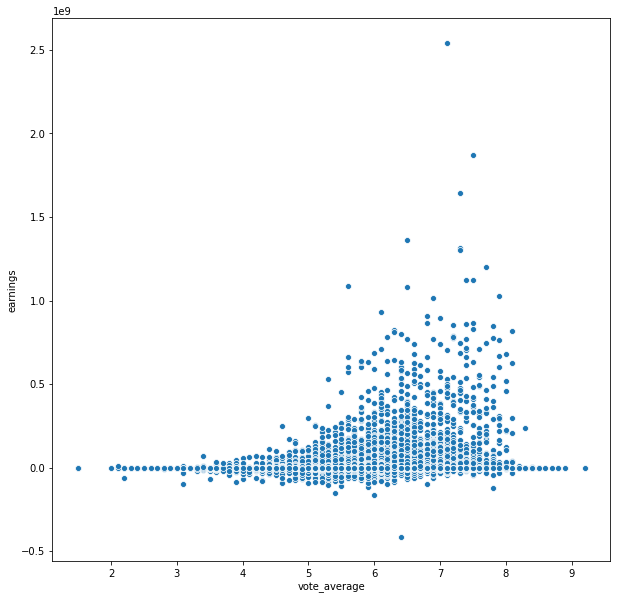

In [0]:
plt.subplots(figsize=(10, 10))

sb.scatterplot(x='vote_average', y='earnings', data=data)

### Director más exitoso (popularidad, ingresos)?

por popularidad

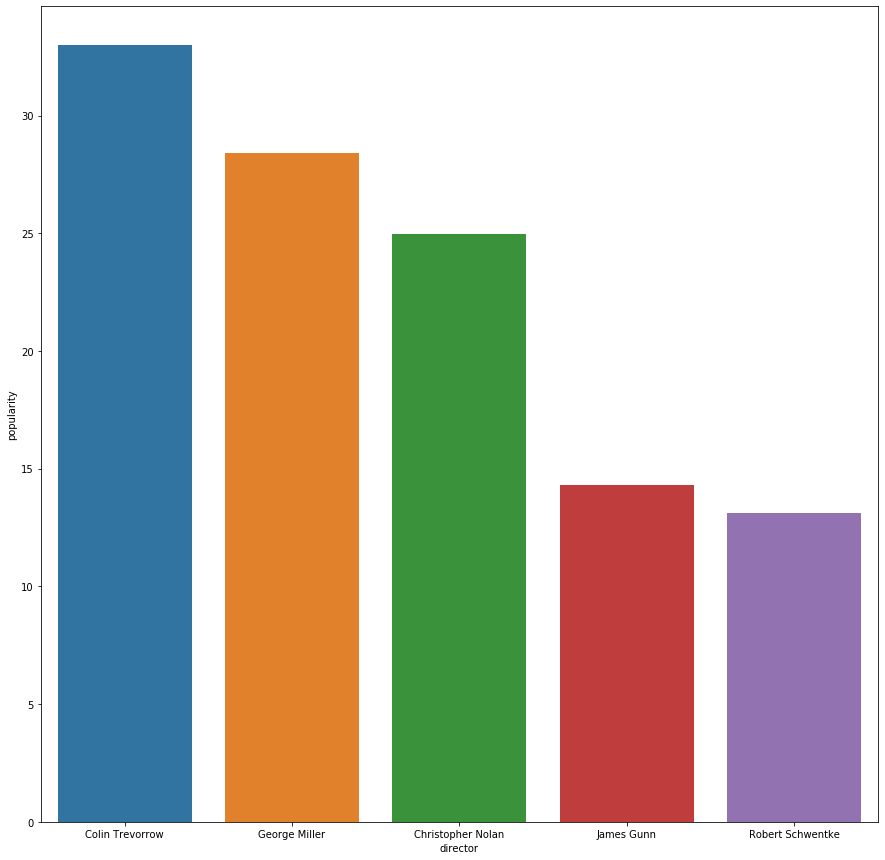

In [0]:
plt.subplots(figsize=(15, 15))
sb.barplot(y='popularity', x='director', data=data.sort_values('popularity', ascending=False).head(5))

Por ganancias

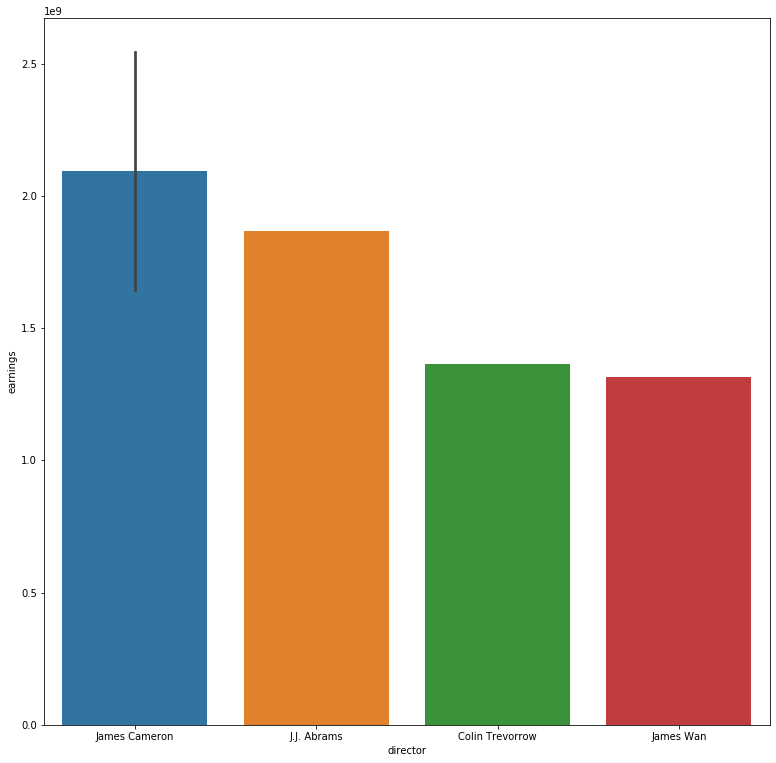

In [0]:
plt.subplots(figsize=(13, 13))
sb.barplot(y='earnings', x='director', data=data.sort_values('earnings', ascending=False).head(5))

### Tiene la duración que  ver con la taquilla?

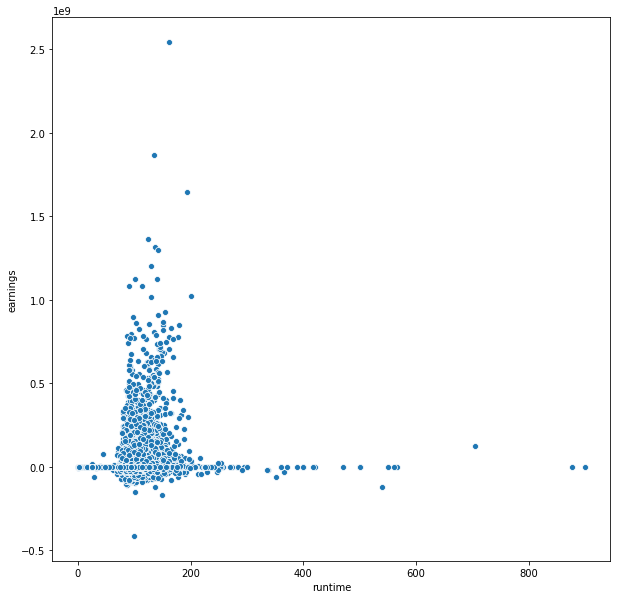

In [0]:
plt.subplots(figsize=(10, 10))
sb.scatterplot(x='runtime', y='earnings', data=data)

### Actores que tienen más taquilla?

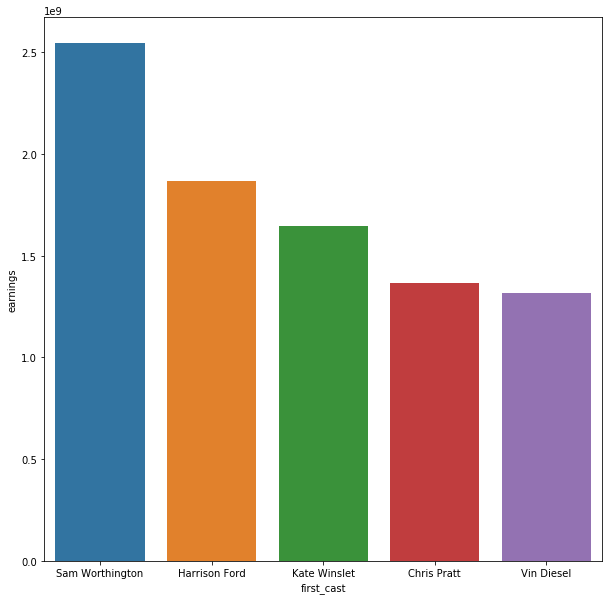

In [0]:
plt.subplots(figsize=(10, 10))
sb.barplot(y='earnings', x='first_cast', data=data.sort_values('earnings', ascending=False).head(5))

### Fechas más propicias para películas exitosas?

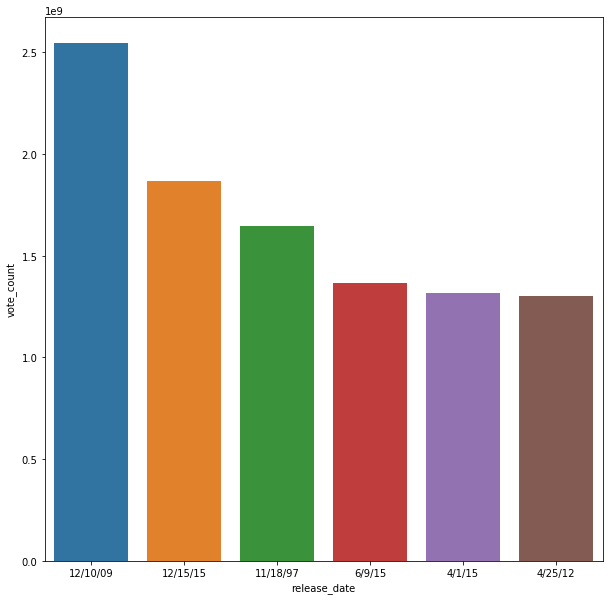

In [0]:
data['vote_count'] = data[['budget', 'revenue']].apply(lambda row: row['revenue'] - row['budget'], axis=1)
plt.subplots(figsize=(10, 10))
sb.barplot(y='vote_count', x='release_date', data=data.sort_values('vote_count', ascending=False).head(6))

### Relación entre género y calificación?

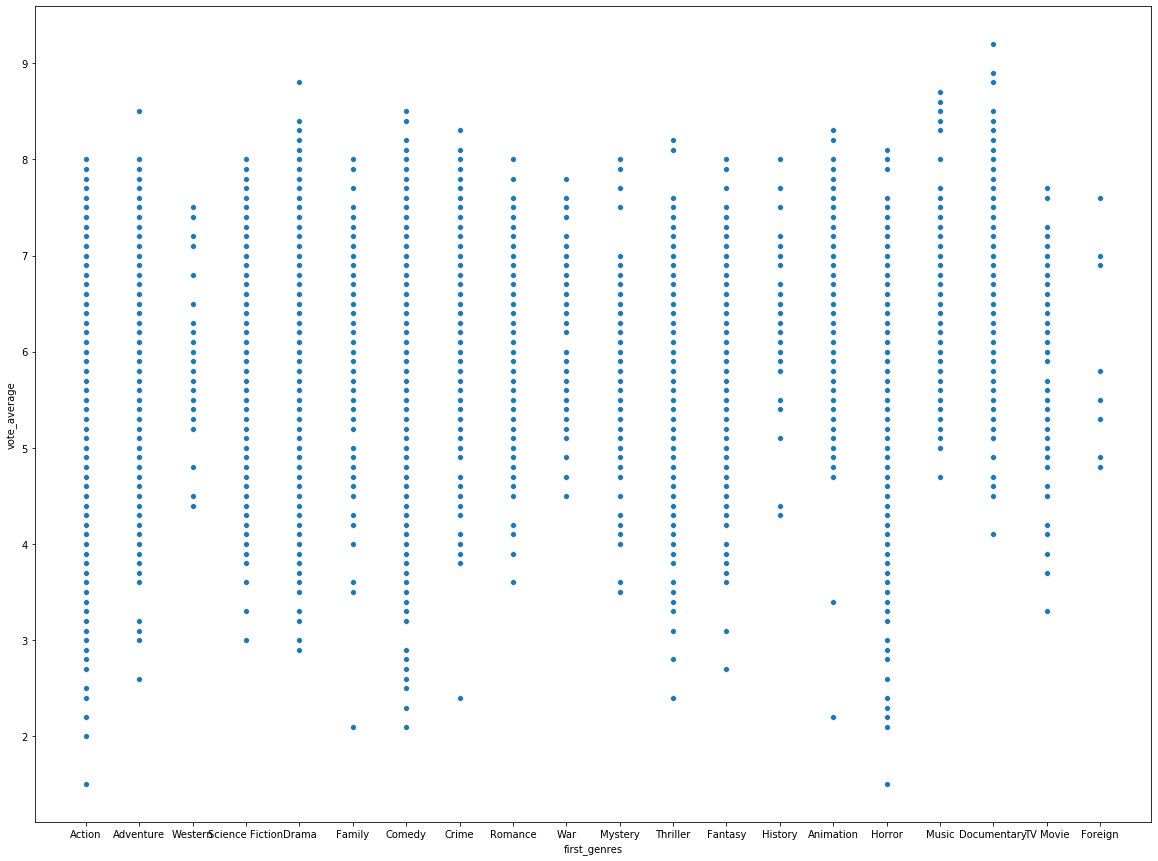

In [0]:
plt.subplots(figsize=(20, 15))
sb.scatterplot(x='first_genres', y='vote_average', data=data)

### Géneros que predominan en épocas del año?

### género que tiene más pérdidas?

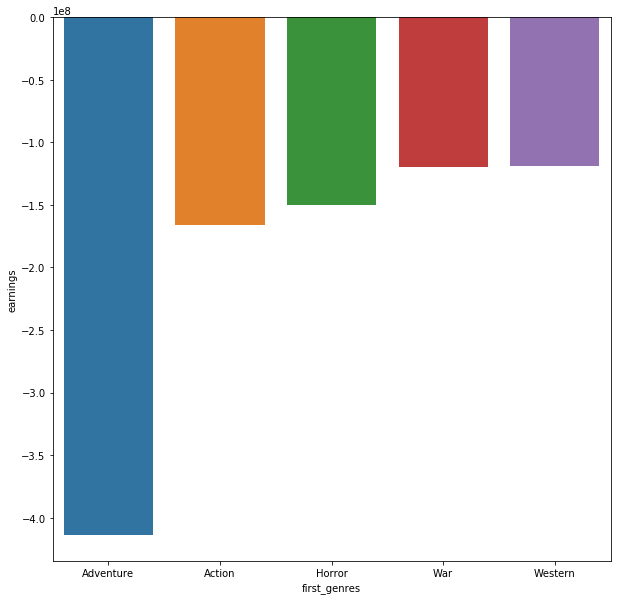

In [0]:
data['earnings'] = data[['budget', 'revenue']].apply(lambda row: row['revenue'] - row['budget'], axis=1)
plt.subplots(figsize=(10, 10))
sb.barplot(y='earnings', x='first_genres', data=data.sort_values('earnings', ascending=True).head(5))

# Clustering

In [0]:
!pip install fuzzy-c-means

In [0]:
!pip install scikit-fuzzy

     |████████████████████████████████| 1.0MB 4.8MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894070 sha256=822a2698e67e1c629d15a9ba5e40cb301e7599373f5a9e14e6c8dcbd9af6f0d2
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


## Seleccion de variables a utilizar

- budget
- popularity
- Revenue
- runtime
- vote_average
- earnings

Estas se escogieron debido a que los algortimos de clustering trabajan con variables numericas.

In [0]:
# 'budget', 'popularity', 'revenue', 'runtime', 'vote_average','earnings'
X = np.array(data[['budget', 'popularity']])

## Seleccion del numero de clusters
### Se utiliza la grafica de codo

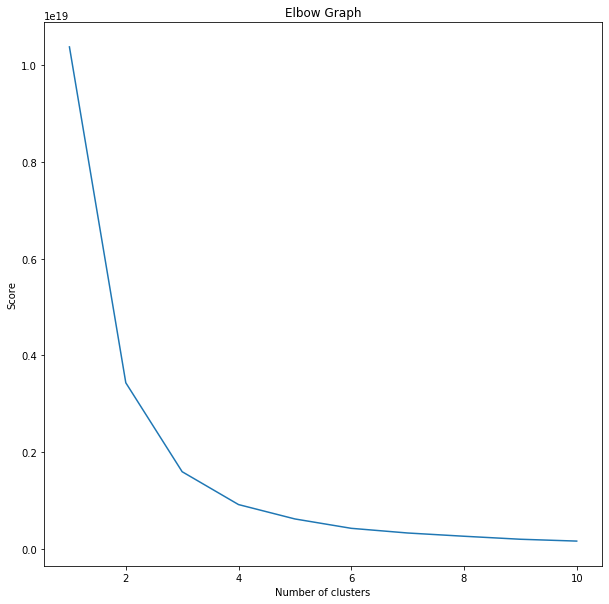

In [0]:
clusterNumber = range(1,11)
wcss = []
for i in clusterNumber:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.subplots(figsize=(10, 10))
plt.plot(clusterNumber, wcss)
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.title("Elbow Graph")
plt.show()

3 clusters se van a estar utilizando

#K means

Se adapta kmeans al modelo

In [0]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

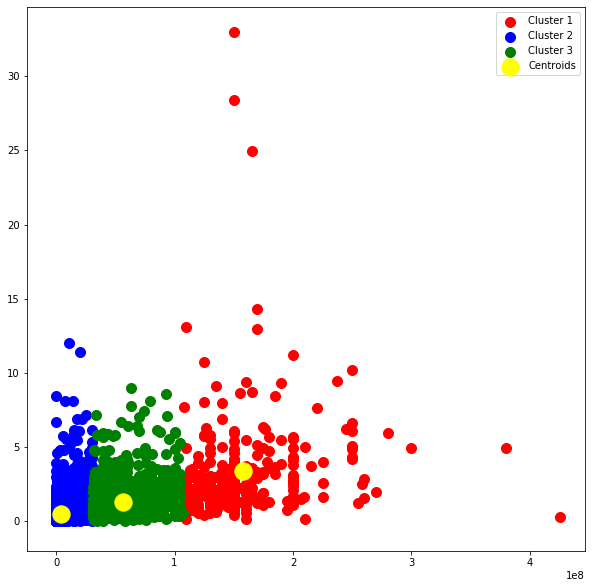

In [0]:
# Visualising the clusters
plt.subplots(figsize=(10, 10))
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
#plt.scatter(X[y_kmeans == 3, 0], X[y_kmeans == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.legend()
plt.show()

# Clustering Jerarquico

In [0]:
dendograma = sch.dendrogram(sch.linkage(X, method='ward'))

In [0]:
hc = cluster.AgglomerativeClustering(n_clusters=3,affinity='euclidean',linkage='ward')
especieHC = hc.fit_predict(X)
especieHC
X

array([[1.5000000e+08, 3.2985763e+01],
       [1.5000000e+08, 2.8419936e+01],
       [1.1000000e+08, 1.3112507e+01],
       ...,
       [0.0000000e+00, 6.5141000e-02],
       [0.0000000e+00, 6.4317000e-02],
       [1.9000000e+04, 3.5919000e-02]])

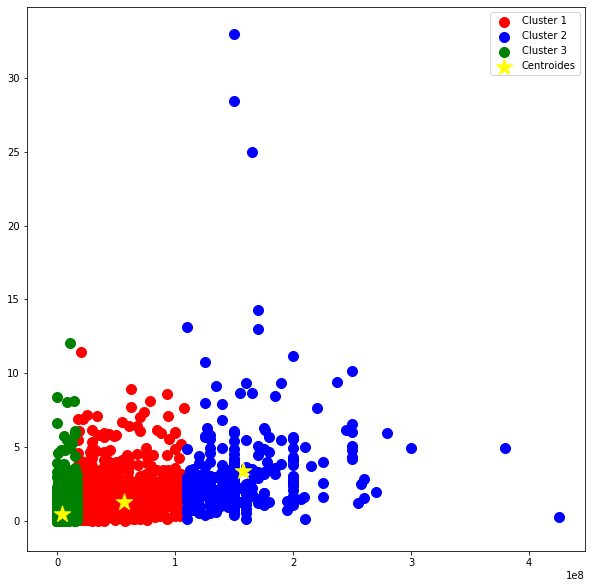

In [0]:
plt.subplots(figsize=(10, 10))
plt.scatter(X[especieHC == 0, 0], X[especieHC == 0, 1],s=100,c='red', label = "Cluster 1")
plt.scatter(X[especieHC == 1, 0], X[especieHC == 1, 1],s=100,c='blue', label = "Cluster 2")
plt.scatter(X[especieHC == 2, 0], X[especieHC == 2, 1],s=100,c='green', label = "Cluster 3")
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], s=300, c="yellow",marker="*", label="Centroides")
plt.legend()

# Fuzzy c-means


In [0]:
# fit the fuzzy-c-means
fcm = FCM(n_clusters=3)
fcm.fit(X)

# outputs
# Se calculan los centroides con un metodo de la liberia
fcm_centers = fcm.centers
fcm_labels  = fcm.u.argmax(axis=1)


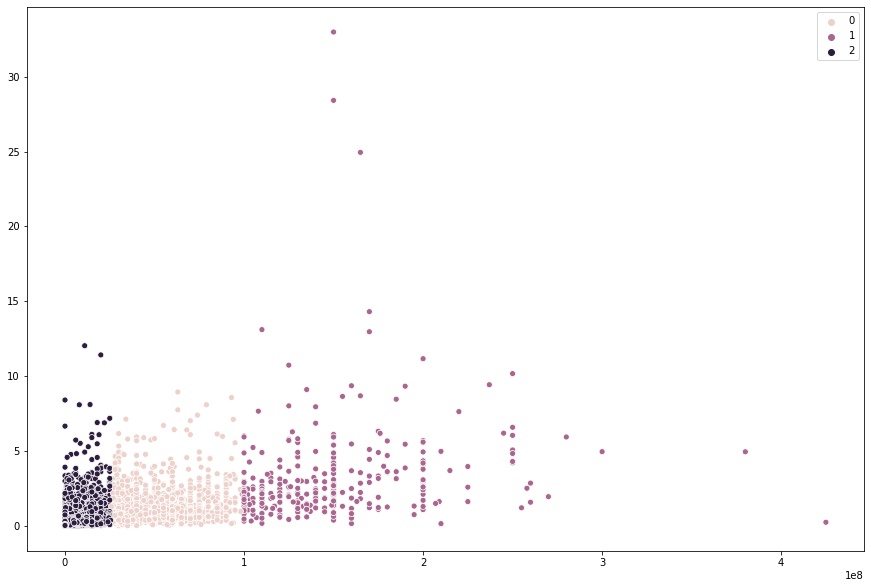

In [0]:
# plot result
%matplotlib inline
axes = plt.subplots(figsize=(15,10))
fuzsb(X[:,0], X[:,1], ax=axes[1], hue=fcm_labels)
plt.show()

# Discusión

Tipos de Clusters 

1.   **Clustering Fuzzu C-meanss:** El agrupamiento difuso es una clase de algoritmos de agrupamiento donde cada elemento tiene un grado de pertenencia difuso a los grupos, es decir que algunos elementos también pueden ser parte de otro centroide pero de una manera difusa como bien lo dice su nombre aunque este de un solo color.
2.   **k-means clustering:**es un método de agrupamiento, que tiene como objetivo la partición de un conjunto de n observaciones en k grupos en el que cada observación pertenece al grupo cuyo valor medio es más cercano, Y a diferencia de clustering fuzzy cada dato tiene solo un centroide.
3.   **clustering jerarquico:**es un método de análisis de grupos puntuales, el cual busca construir una jerarquía de grupos. Estrategias para agrupamiento jerárquico generalmente caen en dos tipos:

    * **Aglomerativas:** Este es un acercamiento ascendente: cada observación comienza en su propio grupo, y los pares de grupos son mezclados mientras uno sube en la jerarquía.
    * **Divisivas:** Este es un acercamiento descendente, todas las observaciones comienzan en un grupo, y se realizan divisiones mientras uno baja en la jerarquía.

en este caso se uso la agrupacion de Agloerativas.


Como se puede observar anteriormente en las graficas se ve que para las variables y el data set utilizado los 3 tipos de algoritmos clustering son muy parecidos en su ejecucion y agrupacion de los datos por lo que no cambian en casi nada por lo tanto se puede concluir de que se puede utilizar cualquiera de estos tres tipos de clustering ya que la diferencia de sus graficas es casi imperceptible.


A continuación dejamos unos diagramas de la representación de agrupaciones de los tres tipos de algoritmos de clustering que utilizamos.

Algoritmo Fuzzy C-Means
![algoritmo fuzzy C-Means](https://i.ibb.co/WgGhyGj/fuzzy.png)




> Algoritmo Jerárquico
![Algoritmo Jerárquico](https://i.ibb.co/m626zz0/jerarquico.png)



>   Algoritmo K-means
![Algoritmo K-means](https://i.ibb.co/VxNTQW3/kmeans.png)


